# Upgrade OpenCV in colab

In [1]:
pip install --upgrade opencv-python

In [2]:
import numpy as np
import cv2
from google.colab.patches import cv2_imshow # colab does not support cv2.imshow()

# Modify the [classes].names

Notify the line number of the classes you want to keep. In our case we only want one class to be retreived : laptop (line 54).  
Change all the other classes name to the same label name: in our case we're going to use 'hide':  
hide  
hide  
hide  
laptop  
hide  
hide  
Save the file as for example coco_laptop.names

# Variables

In [27]:
ROOT_COLAB = '/content/drive/MyDrive/Colab Notebooks/YOLO'
YOLO_CONFIG = ROOT_COLAB + '/oc_data/'
COCO_LABELS_FILE = YOLO_CONFIG + 'coco_laptop.names'
YOLO_CONFIG_FILE = YOLO_CONFIG + 'yolov4.cfg'
YOLO_WEIGHTS_FILE = YOLO_CONFIG + 'yolov4.weights'
LABELS_FROM_FILE = False
IMAGE_FILE = 'yoloimg3.jpg'
IMAGE = cv2.imread(ROOT_COLAB + '/' + IMAGE_FILE)
CONFIDENCE_MIN = 0.5

# Show image

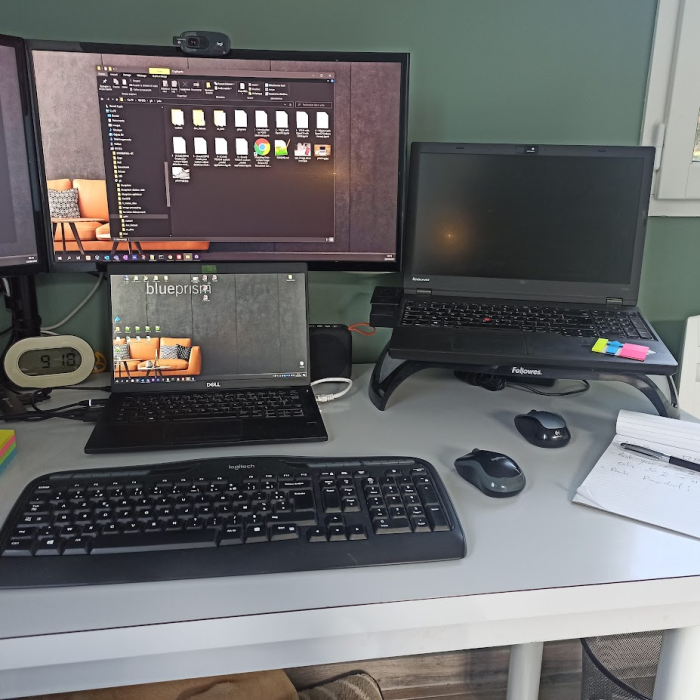

In [28]:
# Little function to resize in keeping the format ratio
# Source: https://stackoverflow.com/questions/35180764/opencv-python-image-too-big-to-display
def ResizeWithAspectRatio(_image, width=None, height=None, inter=cv2.INTER_AREA):
    dim = None
    image = _image.copy()
    (h, w) = image.shape[:2]
    if width is None and height is None:
        return image
    if width is None:
        r = height / float(h)
        dim = (int(w * r), height)
    else:
        r = width / float(w)
        dim = (width, int(h * r))
    return cv2.resize(image, dim, interpolation=inter)

cv2_imshow(ResizeWithAspectRatio(IMAGE, width=700)) 

## Read labels (only one in this case)

In [29]:
with open(COCO_LABELS_FILE, 'rt') as f:
    labels = f.read().rstrip('\n').split('\n')
len(labels)

80

# Prepare YOLO / OpenCV

In [31]:
(H, W) = IMAGE.shape[:2]
yolo = cv2.dnn.readNetFromDarknet(YOLO_CONFIG_FILE, YOLO_WEIGHTS_FILE)
yololayers = [yolo.getLayerNames()[i[0] - 1] for i in yolo.getUnconnectedOutLayers()]
blobimage = cv2.dnn.blobFromImage(IMAGE, 1 / 255.0, (416, 416),	swapRB=True, crop=False)
yolo.setInput(blobimage)

# Apply YOLO / OpenCV

In [32]:
layerOutputs = yolo.forward(yololayers)

In [33]:
boxes_detected = []
confidences_scores = []
labels_detected = []

# loop over each of the layer outputs
for output in layerOutputs:
  # loop over each of the detections
  for detection in output:
    # extract the class ID and confidence (i.e., probability) of the current object detection
    scores = detection[5:]
    classID = np.argmax(scores)
    confidence = scores[classID]

    # Take only predictions with confidence more than CONFIDENCE_MIN thresold
    if (confidence > CONFIDENCE_MIN and labels[classID] != "hide"):

      # Bounding box
      box = detection[0:4] * np.array([W, H, W, H])
      (centerX, centerY, width, height) = box.astype("int")

      # Use the center (x, y)-coordinates to derive the top and left corner of the bounding box
      x = int(centerX - (width / 2))
      y = int(centerY - (height / 2))

      # update our result list (detection)
      boxes_detected.append([x, y, int(width), int(height)])
      confidences_scores.append(float(confidence))
      labels_detected.append(classID)

In [34]:
nb_results = len(boxes_detected)
nb_results

8

# Apply NMS Algorithm

In [35]:
final_boxes = cv2.dnn.NMSBoxes(boxes_detected, confidences_scores, 0.5, 0.5)

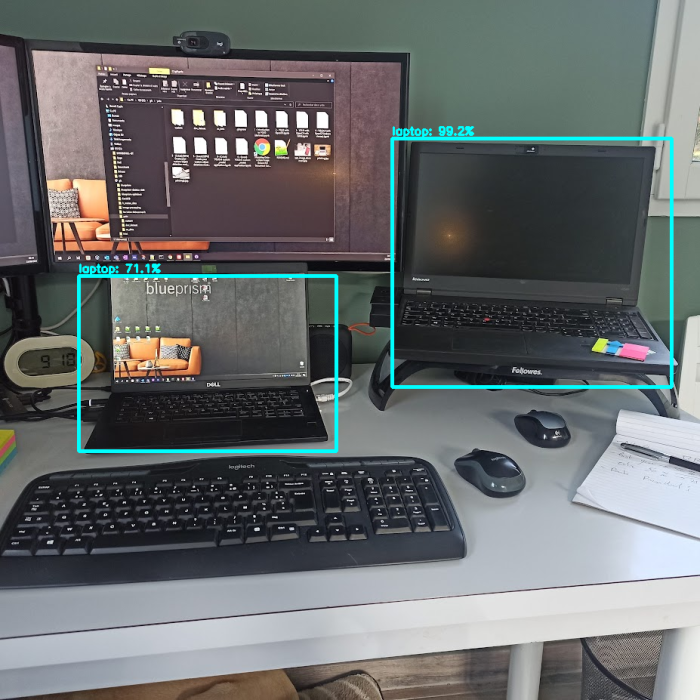

In [40]:
image = IMAGE.copy()
# loop through the final set of detections remaining after NMS and draw bounding box and write text
for max_valueid in final_boxes:
    max_class_id = max_valueid[0]

    # extract the bounding box coordinates
    (x, y) = (boxes_detected[max_class_id][0], boxes_detected[max_class_id][1])
    (w, h) = (boxes_detected[max_class_id][2], boxes_detected[max_class_id][3])

    # draw a bounding box rectangle and label on the image
    color = [255, 255, 0]
    cv2.rectangle(image, (x, y), (x + w, y + h), [255, 255, 0], 3)
    
    score = str(round(float(confidences_scores[max_class_id]) * 100, 1)) + "%"
    text = "{}: {}".format(labels[labels_detected[max_class_id]], score)
    cv2.putText(image, text, (x, y - 5), cv2.FONT_HERSHEY_SIMPLEX, 0.5, color, 2)

cv2_imshow(ResizeWithAspectRatio(image, width=700))

In [37]:
color

[74, 148, 15]